# Example: Compare distributions for common particles in two models

In this example, we generate the pseudorapidity and Feynman-x distributions for selected particles in two models and compare them visually.

Requires extra packages: matplotlib, tqdm, boost-histogram, particle, joblib

In [1]:
import matplotlib.pyplot as plt
import boost_histogram as bh
from tqdm import tqdm
from particle import literals as lp, Particle
import joblib  # only joblib works reliably in notebooks
import numpy as np

from chromo.constants import GeV
from chromo.kinematics import CenterOfMass
import chromo.models as im

In [2]:
# We want to simulate pp interactions at 1 TeV center-of-mass

# The event kinematics objects defines the collision and its frame.
# Here we want pp collisions at 1 TeV center-of-mass energy.
ekin = CenterOfMass(
    100 * GeV,
    "proton",
    "proton"
)

# How many events to generate
n_events = 10000

In [3]:
pid_axis = bh.axis.IntCategory([
    x.pdgid for x in (lp.pi_0, lp.pi_plus, lp.pi_minus, lp.K_plus, lp.K_minus, lp.proton, lp.antiproton)
])

models = [
    im.EposLHC,
    im.Sibyll21,
    im.Sibyll23d,
    im.QGSJet01d,
    im.QGSJetII04,
    im.Pythia6,
    im.Pythia8,
]

@joblib.delayed
def run(Model):    
    # Create mode instance here.
    # This typically generates a banner for each model.
    # Models can only be created once.

    m = Model(ekin, seed=1)
    m.set_stable(lp.pi_0.pdgid)

    # Histogram for Feynman-x distributions
    hx = bh.Histogram(pid_axis, bh.axis.Regular(30, -1, 1))

    # Histogram for pseudorapidity distributions
    heta = bh.Histogram(pid_axis, bh.axis.Regular(30, -7, 7))

    for event in tqdm(m(n_events), total=n_events):
        event = event.final_state() # select only final state particles
        with np.errstate(divide="ignore", invalid="ignore"):
            hx.fill(event.pid, event.xf)
            heta.fill(event.pid, event.eta)

    return m.label, hx, heta

with joblib.Parallel(n_jobs=10, batch_size=1) as pool:
    results = pool(run(m) for m in models)

results = {label: rest for (label, *rest) in results}


 |                                                  |
 |                 S I B Y L L  2.1                 |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                   Ralph ENGEL                    |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 | Publication to be cited when using this program: |
 | R. Engel et al., Proc. 26th ICRC, 1 (1999) 415   |
 |                                                  |
 | last modified:  28. Sept. 2001 by R. Engel       |


 Table: J, sqs,  PT_cut,  SIG_tot,  SIG_inel,  B_el,  rho,  <n_s>,  <n_h>
 ------------------------------------------------------------------------
    1   1.000E+01    1.45   38.33   30.88   10.83  -0.185   1.964   0.003
 |                                                  |
 |                 S

/home/anatoli/devel_wsl/chromo/src/chromo/models/qgsjet.py:58: RuntimeWarning: stable particles cannot be changed in QGSJet01d
  warnings.warn(
  2%|▏         | 239/10000 [00:00<00:04, 2382.82it/s]s]

    2   6.310E+05    7.81  215.78  139.15   28.45   0.125   0.246   7.909
    2   7.943E+05    8.08  223.78  143.66   29.23   0.125   0.232   8.004
    2   1.000E+06    8.37  231.89  148.21   30.02   0.125   0.219   8.090
    2   1.259E+06    8.67  240.09  152.81   30.83   0.125   0.207   8.172
    2   1.585E+06    8.97  248.39  157.46   31.64   0.125   0.196   8.249
    2   1.995E+06    9.28  256.79  162.15   32.47   0.125   0.185   8.324
    2   2.512E+06    9.61  265.28  166.88   33.30   0.125   0.175   8.398
    2   3.162E+06    9.94  273.86  171.66   34.15   0.125   0.165   8.470
    2   3.981E+06   10.29  282.53  176.48   35.01   0.125   0.156   8.542
    2   5.012E+06   10.64  291.29  181.34   35.88   0.125   0.148   8.615
    2   6.310E+06   11.00  300.14  186.25   36.76   0.125   0.140   8.687
    2   7.943E+06   11.38  309.08  191.19   37.64   0.125   0.133   8.756
    2   1.000E+07   11.77  318.10  196.18   38.54   0.125   0.126   8.819

 Table: J, sqs,  PT_cut,  SIG_tot,  S

 42%|████▏     | 4224/10000 [00:00<00:00, 10565.80it/s]

 SIG_AIR_INI: initializing target: (i,A)           3          16 oxy..


 24%|██▍       | 2421/10000 [00:05<00:16, 447.43it/s]

 done
  qgaini: nuclear cross sections readout from the file sectnu-II-04


/home/anatoli/devel_wsl/chromo/src/chromo/models/qgsjet.py:58: RuntimeWarning: stable particles cannot be changed in QGSJetII04
  warnings.warn(
100%|██████████| 10000/10000 [00:25<00:00, 389.24it/s]


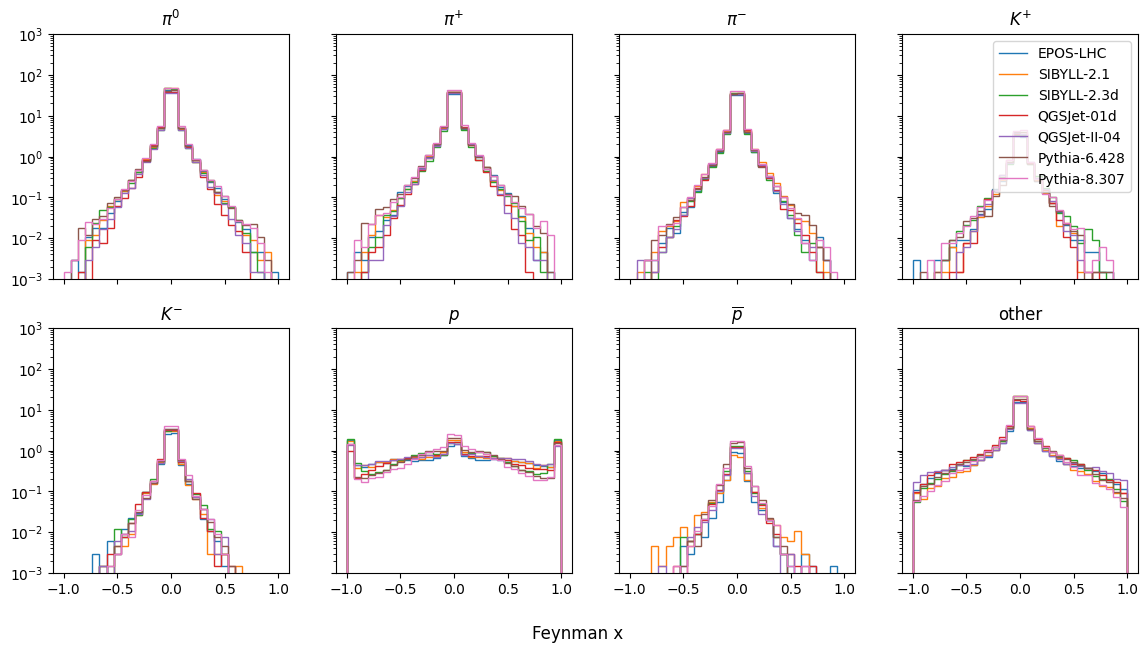

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

# boost-histogram axes contain overflow bins to count everything else,
# we use this here to show a histogram of all other particles
labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in pid_axis]
labels += ["other"]

for model, (hx, heta) in results.items():
    a = hx.axes[1]
    values = hx.values(True) # this returns the full histogram including overflow bins
    values = values[:, 1:-1] # strip the overflow bins from the second axis
    labels = [f"${Particle.from_pdgid(pid).latex_name}$" for pid in hx.axes[0]]
    labels += ["other"]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e3)
fig.supxlabel("Feynman x")
ax[0, -1].legend();

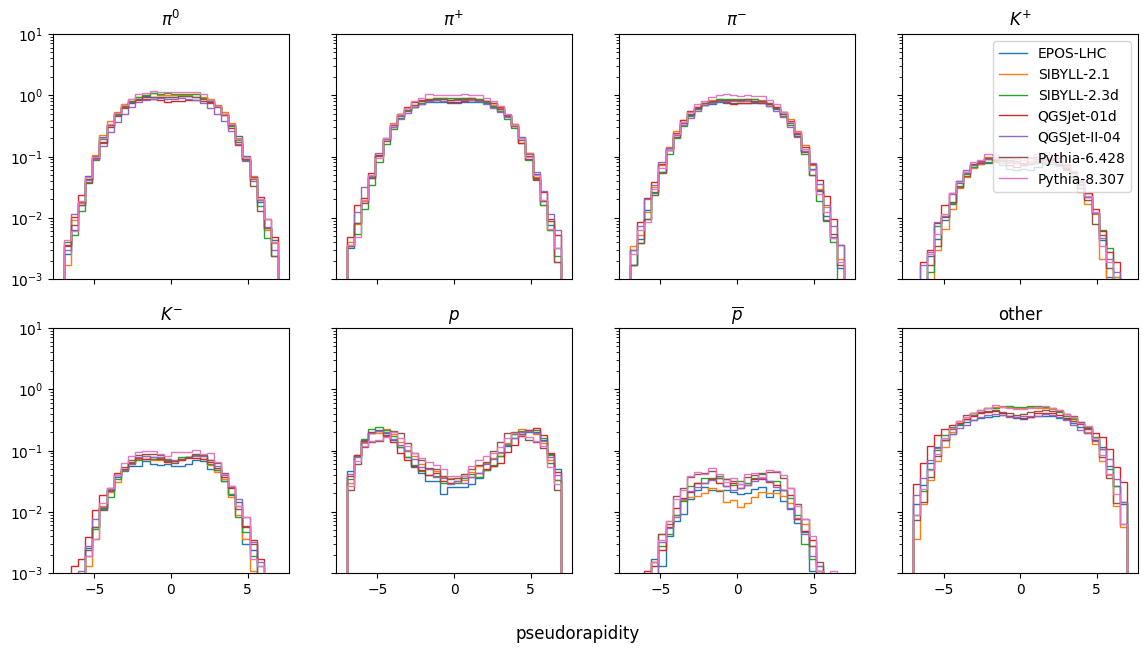

In [5]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=True, sharey=True)

for model, (hx, heta) in results.items():
    a = heta.axes[1]
    values = heta.values(True)
    values = values[:, 1:-1]
    for i, (label, axi) in enumerate(zip(labels, ax.flat)):
        axi.stairs(values[i] / n_events / a.widths, a.edges, label=model)
        axi.set_title(label)
plt.semilogy()
plt.ylim(1e-3, 1e1)
fig.supxlabel("pseudorapidity")
ax[0, -1].legend();